In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-24'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664301442,43379,32437,cancel,0xf22486a7aac772d3a22b93d2593e71ce743be295,NaN,NaN,sneakers,common,ranger,...,504.0,8544.0,30282,8517,280,3394,6533,11838,93.0,1.436214
1,1664301385,43181,40692,cancel,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,NaN,NaN,sneakers,rare,ranger,...,503.0,8544.0,30282,8517,280,3397,6533,11838,93.0,1.446281
2,1664301385,43522,17317,sell,0x9fc140825605781abc210a1cb98ee68f8a27b80f,NaN,0.64,sneakers,common,hiker,...,503.0,8544.0,NaN,NaN,NaN,NaN,NaN,NaN,93.0,1.446281
3,1664301349,43193,60412,cancel,0xda92f9ce0f36f8a404e199b1282f7514800f59c8,NaN,NaN,sneakers,rare,coacher,...,504.0,8544.0,30282,4584,280,3398,6533,11838,93.0,1.450413
4,1664301334,43182,43027,cancel,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,NaN,NaN,sneakers,rare,ranger,...,504.0,8544.0,30282,8517,280,3398,6534,11838,93.0,1.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59160,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
59161,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
59162,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
59163,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59165 entries, 0 to 59164
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  41223 non-null  float64
 1   time_ownership             41223 non-null  float64
 2   wallet_box_mint            41223 non-null  float64
 3   wallet_sneaker_mint        41223 non-null  float64
 4   time_level_up              38008 non-null  float64
 5   time_level_up_for_mint     41239 non-null  float64
 6   base_mint_price_amt        41239 non-null  float64
 7   base_mint_price_azy        41239 non-null  float64
 8   base_mint_price_bnb        31216 non-null  float64
dtypes: float64(9)
memory usage: 4.1 MB


In [12]:
data.genesis

0        False
1        False
2         True
3        False
4        False
         ...  
59160     True
59161    False
59162    False
59163    False
59164     True
Name: genesis, Length: 59165, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
6,1664301313,42986,52050,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,hiker,...,504.0,8545.0,30282,9257,280,3399,6534,11838,93.0,1.454545
8,1664301286,43480,46214,buy,0x1f3371752a645ef4d0ddfbe85c26c939b864825f,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,505.0,8545.0,30282,7924,280,3399,6534,11838,93.0,1.462810
10,1664301241,43482,37697,buy,0x5dd24de8af05b69bf75eaa8ade81715d8c4bcb40,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,ranger,...,506.0,8544.0,30282,8517,280,3399,6535,11838,93.0,1.471074
11,1664301205,42762,37087,buy,0xd4a6fb395f3e424285000ed57b13a413529715a2,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,506.0,8544.0,30282,7924,280,3400,6536,11838,93.0,1.475207
22,1664301049,43077,36893,buy,0x8afab49dfb0ca03ab127f5ea58e3d150087c1903,0x626d11d87adda0bec5e7147e19b4d755ba13551a,0.58,sneakers,common,ranger,...,510.0,8542.0,30280,8517,279,3400,6535,11836,92.0,1.493827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59102,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
59125,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
59139,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
59144,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

cancel_count_24H more then expected. get: 1348 | expected: 1000


In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10488 entries, 6 to 59158
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        10488 non-null  int64  
 1   mrk_id                                           10488 non-null  int64  
 2   token_id                                         10488 non-null  int64  
 3   event                                            10488 non-null  object 
 4   wallet_from                                      10476 non-null  object 
 5   wallet_to                                        10488 non-null  object 
 6   price                                            10488 non-null  float64
 7   item_type                                        10488 non-null  object 
 8   rarity                                           10488 non-null  object 
 9   sneaker_type                

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10488 entries, 6 to 59158
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  10488 non-null  float64
 1   time_ownership             10488 non-null  float64
 2   wallet_box_mint            10488 non-null  float64
 3   wallet_sneaker_mint        10488 non-null  float64
 4   time_level_up              10488 non-null  float64
 5   time_level_up_for_mint     10488 non-null  float64
 6   base_mint_price_amt        10488 non-null  float64
 7   base_mint_price_azy        10488 non-null  float64
 8   base_mint_price_bnb        8098 non-null   float64
dtypes: float64(9)
memory usage: 819.4 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
6,1.657823e+09,24083.0,19.0,17.0,900.0,1800.0,300.0,200.0,0.532045
8,1.663518e+09,3996.0,0.0,0.0,1680.0,1800.0,300.0,200.0,0.532045
10,1.657800e+09,3894.0,14.0,20.0,900.0,1800.0,300.0,200.0,0.532045
11,1.659543e+09,32227.0,7.0,1.0,900.0,1800.0,300.0,200.0,0.532045
22,1.659442e+09,20528.0,7.0,11.0,900.0,1800.0,300.0,200.0,0.531905
...,...,...,...,...,...,...,...,...,...
59102,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
59125,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
59139,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
59144,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10488 entries, 6 to 59158
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        10488 non-null  int64  
 1   mrk_id                                           10488 non-null  int64  
 2   token_id                                         10488 non-null  int64  
 3   event                                            10488 non-null  object 
 4   wallet_from                                      10476 non-null  object 
 5   wallet_to                                        10488 non-null  object 
 6   price                                            10488 non-null  float64
 7   item_type                                        10488 non-null  object 
 8   rarity                                           10488 non-null  object 
 9   sneaker_type                

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
6,1664301313,42986,52050,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,hiker,...,504.0,8545.0,30282,9257,280,3399,6534,11838,93.0,1.454545
8,1664301286,43480,46214,buy,0x1f3371752a645ef4d0ddfbe85c26c939b864825f,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,505.0,8545.0,30282,7924,280,3399,6534,11838,93.0,1.462810
10,1664301241,43482,37697,buy,0x5dd24de8af05b69bf75eaa8ade81715d8c4bcb40,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,ranger,...,506.0,8544.0,30282,8517,280,3399,6535,11838,93.0,1.471074
11,1664301205,42762,37087,buy,0xd4a6fb395f3e424285000ed57b13a413529715a2,0xd7d9f33fbd185b862e0ac9b576abdd413530ea1b,0.58,sneakers,common,sprinter,...,506.0,8544.0,30282,7924,280,3400,6536,11838,93.0,1.475207
22,1664301049,43077,36893,buy,0x8afab49dfb0ca03ab127f5ea58e3d150087c1903,0x626d11d87adda0bec5e7147e19b4d755ba13551a,0.58,sneakers,common,ranger,...,510.0,8542.0,30280,8517,279,3400,6535,11836,92.0,1.493827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59102,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
59125,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
59139,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
59144,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
58669,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
58618,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
58415,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
58220,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
57489,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1664300287,43418,41829,buy,0xd390cf6aa952728f1bae460299172a892f50e723,0xea5b03c317f71ac39c2cd2272694d2f265def386,0.55,sneakers,common,sprinter,...,8541.0,30280,7923,286,3413,6542,11839,93.0,1.578512,2022-09-27 17:38:07
44,1664300590,43227,38787,buy,0x7b84c2b2ddcffe395ee62c6444a9212924574a8b,0x7528c587c5ff7a80f47d7bdc315de3377b39d2c9,2.00,sneakers,uncommon,ranger,...,8542.0,30280,8517,283,3407,6539,11838,93.0,1.549587,2022-09-27 17:43:10
37,1664300836,43515,51096,buy,0x2040870ad0e2771588a4f59a45d81cc8b5ddfcf0,0xec5ff07c939d7b1ea46c1f49839e7dacb00fedce,0.51,sneakers,common,hiker,...,8541.0,30280,9256,282,3403,6536,11837,93.0,1.528689,2022-09-27 17:47:16
33,1664300869,43517,43776,buy,0x2040870ad0e2771588a4f59a45d81cc8b5ddfcf0,0xec5ff07c939d7b1ea46c1f49839e7dacb00fedce,0.50,sneakers,common,hiker,...,8542.0,30280,9256,281,3403,6536,11837,93.0,1.520492,2022-09-27 17:47:49


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11.0

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
44005,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
39767,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

2595

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,1664244805,42347,54861,buy,0xc5f6db77d510244b80875387222dabe06208349d,0xde83a653dd280c540475eee7ce19207df98178b2,0.65,sneakers,common,hiker,...,11834,90.0,0.964481,2022-09-27 02:13:25,3089,4.173333,0xde83a653dd280c540475eee7ce19207df98178b2,0.65,2022-09-27 03:24:17,-0.0325
1186,1664244923,42350,54635,buy,0x17db1949fc175f2c8274a65cfeb83bec84b23212,0x7064b3c119730bb71e0857c9ca81f5c8c5456ee6,0.66,sneakers,common,ranger,...,11834,90.0,0.961853,2022-09-27 02:15:23,3093,4.181333,0x7064b3c119730bb71e0857c9ca81f5c8c5456ee6,0.65,2022-09-27 03:31:05,-0.0425
1187,1664246674,42317,15668,buy,0x16311e4fbc0b2f00621b4ce08a803456bd97aead,0xf369756c17e92370a3792898633ba8216c6984ed,0.67,sneakers,common,sprinter,...,11834,91.0,0.972603,2022-09-27 02:44:34,3080,4.322314,0xf369756c17e92370a3792898633ba8216c6984ed,0.59,2022-09-27 13:31:00,-0.1095
1188,1664252735,42327,33727,buy,0x86149c91c3e072e967c431a5a46fc2a0422c74bf,0x59bf7d0118d204f46dc3d33486bd12f8484c6130,0.65,sneakers,common,sprinter,...,11829,95.0,0.99723,2022-09-27 04:25:35,3088,4.300546,0x59bf7d0118d204f46dc3d33486bd12f8484c6130,0.57,2022-09-27 15:47:42,-0.1085


In [37]:
final_df.profit.median()

0.01649999999999996

In [38]:
final_df.profit.sum()

-11.454274999999999

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

359

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

156

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

15

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
0xda9f0564c09479c9c54e653b05c47bfe663952a6        -5.2
                                                ...   
0xee731ff68f1b70358d4220eb964ed39feb89c6d9      2.3855
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.5595
0xf3df1c64cb2e66400ef968caabfbe665457d25d4       9.014
0x3273af210822c44afd7254510e612e4dbb1040a7      18.916
Name: profit, Length: 359, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

147

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

13

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

469

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba    4.5595
0xf3df1c64cb2e66400ef968caabfbe665457d25d4     9.014
0x3273af210822c44afd7254510e612e4dbb1040a7    18.916
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

246

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

1        1
2        2
28      11
52      51
55      57
        ..
1157     6
1160     5
1173     4
1175     6
1184    15
Name: sell_time, Length: 246, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

5.577

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.181,0.346
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.220,0.365
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,3.116,4.836
52,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,0.072,0.146
55,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,0.091,0.165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,1664111651,39871,31818,buy,0xb794ed9c41014eaa74be9a8ede0b8f287c5999a3,0x3273af210822c44afd7254510e612e4dbb1040a7,0.79,sneakers,common,hiker,...,2001,3.577320,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.84,2022-09-25 19:52:12,0.0080,6,0.0080,0.043,0.188
1160,1664117324,40026,15367,buy,0x00a76804cab86f32ee98e2a17ec633a9090b5b5c,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.70,sneakers,common,sprinter,...,2064,3.606061,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.82,2022-09-25 20:40:05,0.0790,5,0.0790,0.074,0.193
1173,1664168734,40846,21103,buy,0x6cf82ada87a78d3bbc68cabbc18384d1168ba0b9,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.70,sneakers,common,coacher,...,2931,4.522796,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.75,2022-09-26 09:08:15,0.0125,4,0.0125,-0.001,0.089
1175,1664190691,41234,33855,buy,0xe63148b8b61cf410f2a1a49ead4a9c2ba653dcf7,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.70,sneakers,common,hiker,...,3016,4.916667,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.85,2022-09-26 17:28:13,0.1075,6,0.1075,0.025,0.222


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

171

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
467,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
468,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
471,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
479,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
480,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,273.906438,0.066441,0.497715,1657827452.0,4253399.0,3.0,3.0,0,1800.0,300.0,200.0,0.593644,2022-09-23 13:39:18
1121,273.906438,0.066441,0.497715,1657827452.0,4253567.0,3.0,3.0,0,1800.0,300.0,200.0,0.593644,2022-09-23 13:41:00
1126,272.321456,0.066874,0.546200,1662844708.0,943904.0,3.0,3.0,900,1800.0,300.0,200.0,0.650830,2022-09-23 19:16:51
1127,272.761178,0.066314,0.548245,1659990066.0,3523150.0,6.0,12.0,900,1800.0,300.0,200.0,0.651618,2022-09-23 19:50:42


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 467 to 1128
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        171 non-null    int64         
 1   mrk_id                                           171 non-null    int64         
 2   token_id                                         171 non-null    int64         
 3   event                                            171 non-null    object        
 4   wallet_from                                      171 non-null    object        
 5   wallet_to                                        171 non-null    object        
 6   price                                            171 non-null    float64       
 7   item_type                                        171 non-null    category      
 8   rarity                               

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.88it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  3.13it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:00,  3.15it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  3.18it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  3.23it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  3.25it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  3.26it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  3.27it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:02,  3.28it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,4.300000e-01,3.926000e-01
MAE,7.500000e-02,4.970000e-02
MSE,4.900000e-02,1.209000e-01
RMSE,1.440000e-01,1.709000e-01
MAPE,4.415294e+12,1.358561e+13


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,4.300000e-01,3.926000e-01
MAE,7.500000e-02,4.970000e-02
MSE,4.900000e-02,1.209000e-01
RMSE,1.440000e-01,1.709000e-01
MAPE,4.415294e+12,1.358561e+13


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.267,
 'MAE': 0.075,
 'MSE': 0.049,
 'RMSE': 0.222,
 'MAPE': 4389473321024.626}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


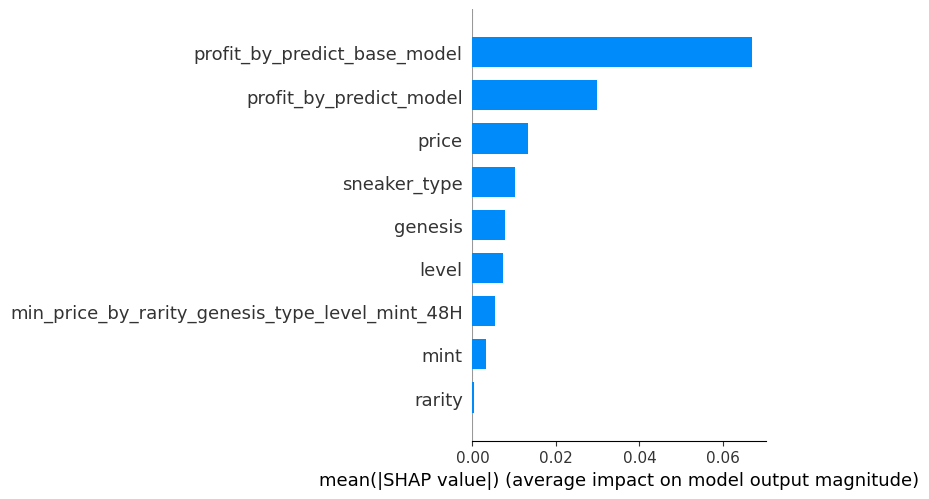

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1001546	total: 682us	remaining: 682ms
1:	learn: 0.0990248	total: 1.53ms	remaining: 762ms
2:	learn: 0.0978527	total: 2.16ms	remaining: 718ms
3:	learn: 0.0967616	total: 2.67ms	remaining: 666ms
4:	learn: 0.0953545	total: 3.22ms	remaining: 640ms
5:	learn: 0.0941208	total: 3.72ms	remaining: 617ms
6:	learn: 0.0933101	total: 4.26ms	remaining: 604ms
7:	learn: 0.0924790	total: 4.79ms	remaining: 594ms
8:	learn: 0.0914731	total: 5.28ms	remaining: 581ms
9:	learn: 0.0906139	total: 5.75ms	remaining: 570ms
10:	learn: 0.0897528	total: 6.22ms	remaining: 559ms
11:	learn: 0.0888339	total: 6.65ms	remaining: 548ms
12:	learn: 0.0880475	total: 7.13ms	remaining: 541ms
13:	learn: 0.0873724	total: 7.53ms	remaining: 530ms
14:	learn: 0.0867496	total: 7.92ms	remaining: 520ms
15:	learn: 0.0861336	total: 8.32ms	remaining: 512ms
16:	learn: 0.0855378	total: 8.67ms	remaining: 501ms
17:	learn: 0.0847129	total: 9.01ms	remaining: 491ms
18:	learn: 0.0836944	total: 9.36ms	remaining: 483ms
19:	learn: 0.0833188	to

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': -1.036, 'MAE': 0.088, 'MSE': 0.009, 'RMSE': 0.096, 'MAPE': 5.38}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

0.516

In [80]:
submission

,profit,pred
0,0.0315,0.158
1,0.0775,0.127
2,-0.0100,0.113
3,0.0080,0.151
4,0.0790,0.168
5,0.0125,0.092
6,0.1075,0.165
7,0.2100,0.170


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

0.516

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': -1.049, 'MAE': 0.089, 'MSE': 0.009, 'RMSE': 0.096, 'MAPE': 5.329}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.0987291	total: 1.29ms	remaining: 1.29s
1:	learn: 0.0979024	total: 1.97ms	remaining: 981ms
2:	learn: 0.0968623	total: 2.55ms	remaining: 848ms
3:	learn: 0.0958777	total: 3.13ms	remaining: 780ms
4:	learn: 0.0950124	total: 3.71ms	remaining: 738ms
5:	learn: 0.0943638	total: 4.22ms	remaining: 700ms
6:	learn: 0.0938349	total: 4.76ms	remaining: 676ms
7:	learn: 0.0926723	total: 5.28ms	remaining: 655ms
8:	learn: 0.0918621	total: 5.72ms	remaining: 630ms
9:	learn: 0.0912868	total: 6.17ms	remaining: 611ms
10:	learn: 0.0908425	total: 6.67ms	remaining: 600ms
11:	learn: 0.0902000	total: 7.18ms	remaining: 591ms
12:	learn: 0.0895842	total: 7.58ms	remaining: 576ms
13:	learn: 0.0889716	total: 8.03ms	remaining: 566ms
14:	learn: 0.0884654	total: 8.26ms	remaining: 543ms
15:	learn: 0.0879547	total: 8.56ms	remaining: 527ms
16:	learn: 0.0871520	total: 8.91ms	remaining: 515ms
17:	learn: 0.0867273	total: 9.22ms	remaining: 503ms
18:	learn: 0.0859564	total: 9.53ms	remaining: 492ms
19:	learn: 0.0852763	t

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
174    0.0080
175    0.0790
176    0.0125
177    0.1075
178    0.2100
Name: target, Length: 179, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663061828,
 'mrk_id': 28651,
 'token_id': 41385,
 'event': 'buy',
 'wallet_from': '0x6d3489da64a34663c54500aee7a748f1efe4d576',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.87,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'coacher',
 'level': 5,
 'base_performance': 2.5,
 'base_fortune': 7.2,
 'base_joy': 6.4,
 'base_durability': 5.2,
 'performance': 19.0,
 'fortune': 10.7,
 'joy': 9.4,
 'durability': 7.7,
 'mint': 2,
 'parent1': 37592.0,
 'parent2': 38844.0,
 'genesis': False,
 'parent1_sneaker_type': 'hiker',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 293.08856531,
 'price_azy': 0.08815466,
 'price_amt': 0.54666385,
 'wallet_from_buy_count': 6.0,
 'wallet_from_all_count': 33.0,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 60,
 'buy_count_24H': 290,
 'buy_count_48H': 524.0,
 'sell_count_12H': 223.0,
 'sell_count_24H': 682,
 'sell_count_48H': 1225.0,
 'cancel_count_12H': 115.0,
 'cancel

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                              common
sneaker_type                                       coacher
genesis                                              False
level                                                    5
mint                                                     2
min_price_by_rarity_genesis_type_level_mint_48H       0.69
price                                                 0.87
profit_by_predict_model                             -0.066
profit_by_predict_base_model                        -0.043
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.001

In [90]:
data.iloc[i]['profit']

-0.0625

iteritems is deprecated and will be removed in a future version. Use .items instead.


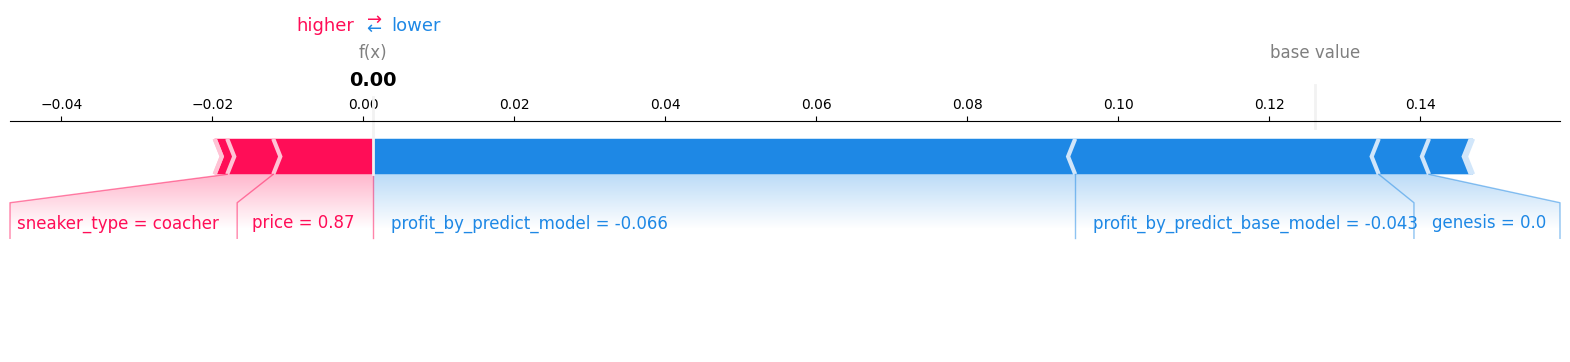

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)